# 9) Download CORS data according to Susana's presentation and compute iono gradients using dual frequency station pairwise.



Iono gradients are calculated with vertical iono range errors (I_vert with dual frequencies) and their Ionospheric pierce point at a single epoch. Using station pairs to calculate gradients.
<img src="ionograd.png">

Calculate gradient with some of the methods, depending on the grid of stations available:<br>
<ul><li>Requires stations apart less than 50Km</li>
<li>Is not affected by relative velocities of front and IPPs</li>
<li>IPP height is 350 Km</li></ul>


In [1]:
import numpy as np
import gpstk
from GNSS_TK import *
import matplotlib.pyplot as plt
%matplotlib inline

###Iono Gradient ZOB1 and GARF
Iono slope [mm/Km] 20-22 Hour 72000-79200 11/20/2003

In [2]:
st1=["data/zob1324.03.n","data/zob13240.03o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2=getdata_stationpair(st1,st2,"GPS 8")

In [3]:
print min(t1),max(t1)
print min(t2),max(t2)

18900.0 85020.0
20550.0 83430.0


In [4]:
print len(IPP1),len(t1),len(Icode1),len(Iphase1),len(VTECphase1),len(ELEV1)
print len(IPP2),len(t2),len(Icode2),len(Iphase2),len(VTECphase2),len(ELEV2)

963 963 963 963 963 963
745 745 745 745 745 745


###Observations between 20  22 hours (72000 and 79200 seconds)

In [5]:
def get_obstimes(t,first,last):
    t=np.array(t)
    #new_t=t[(t>=first) & (t<=last)]
    new_t=t[np.logical_and(t>=first, t<=last)]
    #indices=np.where(np.logical_and(t>=first, t<=last))
    return new_t#,indices[0]
tiempos1=get_obstimes(t1,72000,79200)
tiempos2=get_obstimes(t2,72000,79200)
print tiempos1[:10]
print tiempos2[:10]
print len(tiempos1),len(tiempos2)

[ 72000.  72030.  72060.  72090.  72120.  72150.  72180.  72210.  72240.
  72270.]
[ 72000.  72030.  72060.  72090.  72120.  72150.  72180.  72210.  72240.
  72270.]
239 241


In [6]:
tcommon=np.intersect1d(tiempos1,tiempos2)
print "Samples (every 30 segundos): ",np.size(tcommon)
print "First: ",np.min(tcommon),"Last: ",np.max(tcommon)

Samples (every 30 segundos):  239
First:  72000.0 Last:  79200.0


###First Results: Delay and Slant ZOB GARF

In [7]:
D=[]
gg=[]#gradient
#t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2
IC1,IC2,IPh1,IPh2,IPPs1,IPPs2=[],[],[],[],[],[]
t,EL1,EL2=[],[],[]
print  IPP1[tcommon[0]][0]


525959.002454


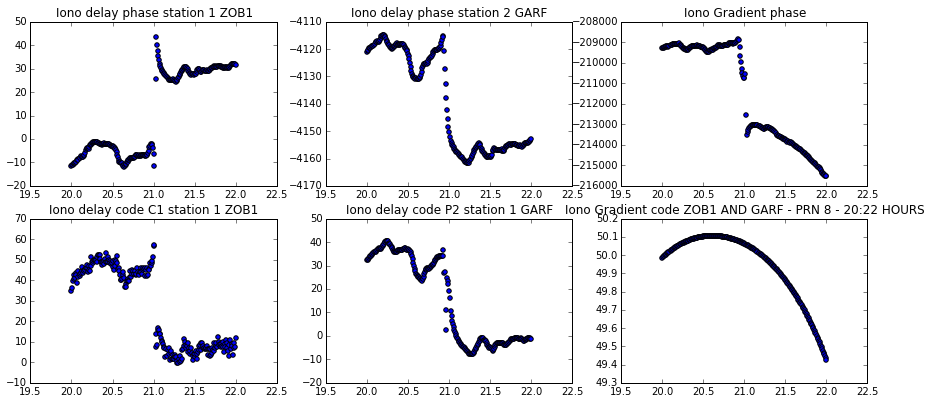

In [8]:
for time in tcommon:
    d=np.sqrt((IPP1[time][0]-IPP2[time][0])**2+(IPP1[time][1]-IPP2[time][1])**2+(IPP1[time][2]-IPP2[time][2])**2)/1000
    if Iphase1[time]<4e7: #ese errorcito
        D.append(d)
        EL1.append(ELEV1[time])
        EL2.append(ELEV2[time])
        IC1.append(Icode1[time])
        IC2.append(Icode2[time])
        IPh1.append(Iphase1[time])
        IPh2.append(Iphase2[time])
        t.append(time)

D=np.array(D)
t=np.array(t)/3600 
IC1=np.array(IC1)
IC2=np.array(IC2)
IP1=np.array(IPh1)
IP2=np.array(IPh2)
EL1=np.array(EL1)
EL2=np.array(EL2)
f1=gpstk.L1_FREQ_GPS
f2=gpstk.L2_FREQ_GPS
alfa=f1**2/(f1**2-f2**2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1 ZOB1")
plt.scatter(t,IP1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2 GARF")
plt.scatter(t,IP2)
plt.subplot(3,3,3)
plt.title("Iono Gradient phase")
DelayP=(alfa*(IP2-IP1)*1000)/D #Km/mm
plt.scatter(t,DelayP)
plt.subplot(3,3,4)
plt.title("Iono delay code C1 station 1 ZOB1")
plt.scatter(t,IC1)
plt.subplot(3,3,5)
plt.title("Iono delay code P2 station 1 GARF")
plt.scatter(t,IC2)
plt.subplot(3,3,6)
plt.title("Iono Gradient code ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
DelayC=(alfa*(IC1-IC2)*1000)/D
plt.scatter(t,D)

#Preprocessing

We can see that there are huge ambiguities on phase measurements and the ones made with the C1 and P2 codes are too noisy. **First we have to make some preprocessing.** <br>From Lee's paper "We first perform pre-processing on the code-
derived, <i>I code</i>, and carrier-derived, <i>I phase </i> , observables, which includes cycle slip detection and correction, short arc removal, outlier removal, and code-carrier smoothing."<br>


#IOD Cycle Slips

**Data jump indicator:** the difference between two adjacent ionospheric delays, ∇Iφ , is examined to detect a
data jump greater than the slip detection threshold of 0.5 m for a nominal day

In [9]:
jumps1=datajump(IP1,t,2.5) #tgap1
print "Data jumps in slant delay station1 : ",jumps1

jumps2=datajump(IP2,t,2.5) #tgap1
print "Data jumps in  in slant delay station2: ",jumps2

Data jumps in slant delay station1 :  [121 122]
Data jumps in  in slant delay station2:  []


**Confirm that  ∇Iφ takes big jumps:** 

In [11]:
print IP1[120],IP1[121],IP1[122],IP1[123]

-11.7022791574 25.7175673109 43.6531762961 40.0875908444


##Continuous arcs are divided into "several" subarcs
Using de datajumps we split our arc into miniarcs

In [12]:
miniarcs1,ntimes1=sub_arcs(IP1,t,jumps1)
print "Total subarcs=",len(miniarcs1)
for i in range(len(miniarcs1)):
    print "Arc ",i," has ",len(miniarcs1[i])," elements"

Total subarcs= 3
Arc  0  has  121  elements
Arc  1  has  1  elements
Arc  2  has  116  elements


In [13]:
miniarcs2,ntimes2=sub_arcs(IP2,t,jumps2)
print "Total subarcs=",len(miniarcs2)
for i in range(len(miniarcs2)):
    print "Arc ",i," has ",len(miniarcs2[i])," elements" 

Total subarcs= 1
Arc  0  has  238  elements


##Short arc Removal
Also, miniarcs with less than 10 elements, or five minutes are removed. **The short arcs need to be discarded because leveling errors for those arcs are typically large and cause ionospheric delay estimation errors. **

In [14]:
miniarcs1,ntimes1=remove_short(miniarcs1,ntimes1)
print len(miniarcs1)

2


In [15]:
miniarcs2,ntimes2=remove_short(miniarcs2,ntimes2)
print len(miniarcs2)

1


##Polinomial fit & Outlier detection and Removal
In this step a polinomyal fit and outlier factor methods are executed on each sub arc. **If the biggest slip for both methods is the same the outlier is confirmed and removed.**

###Polinomial fit

A polynomial fit is performed on the carrier-derived observables, Iphase , and the differential residuals of the fit are computed. If the largest jump between adjacent points exceeds an outlier (or slip) detection parameter of **0.8 meters? or 2.5,** the jump is classified as a potential outlier. 


0
0


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


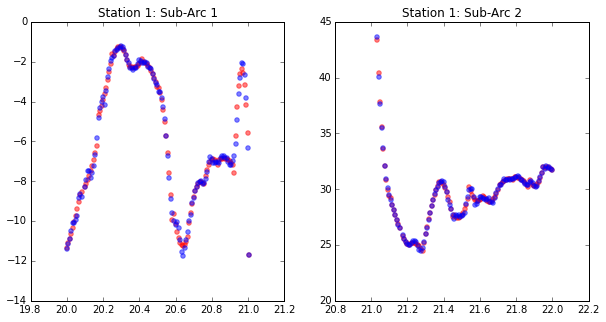

In [16]:
plt.figure(figsize=(10,5))
P1,pslip1=poly_fit(miniarcs1[0],ntimes1[0])
plt.subplot(1,2,1)
plt.title("Station 1: Sub-Arc 1")
plt.scatter(ntimes1[0],P1,color="red",alpha=.5)
plt.scatter(ntimes1[0],miniarcs1[0],color="blue",alpha=.5)
print pslip1

P1,pslip1=poly_fit(miniarcs1[1],ntimes1[1])
plt.subplot(1,2,2)
plt.title("Station 1: Sub-Arc 2")
plt.scatter(ntimes1[1],P1,color="red",alpha=.5)
plt.scatter(ntimes1[1],miniarcs1[1],color="blue",alpha=.5)
print pslip1

0


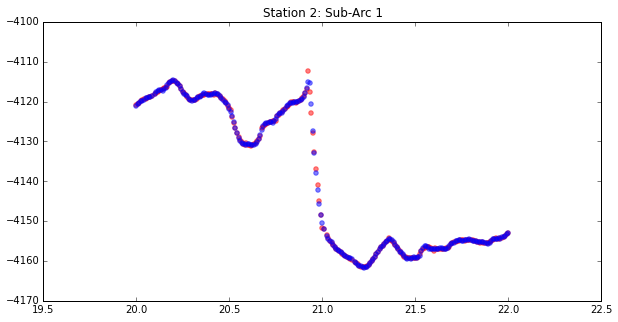

In [17]:
plt.figure(figsize=(10,5)) #this isn's divided 
P2,pslip2=poly_fit(miniarcs2[0],ntimes2[0])
plt.title("Station 2: Sub-Arc 1")
plt.scatter(ntimes2[0],P2,color="red",alpha=.5)
plt.scatter(ntimes2[0],miniarcs2[0],color="blue",alpha=.5)
print pslip2


###Outlier Factor<br>
**Algorithm takes n inputs
x, f(x), k (neighbours) --->OF with the outlier factor for every f(x) and Z (set of outliers, size "m", m < n)** <br>
k=10, neighbours close are observations  close for 5 minutes to the epoch
Second, the difference of I between adjacent points is
computed using the adjacent point difference algorithm in
[16]. The averaged difference (i.e., Outlier Factor (OF)),
between adjacent points of point p at time t p is calculated


In [18]:
outliers1,oslip1=outlier_detect(miniarcs1[0],ntimes1[0]*3600)
print "Elements in OFt: ",outliers1.size
print "Biggest slip detected in: ",oslip1
print miniarcs1[0][oslip1]
print ntimes1[0][oslip1]

Elements in OFt:  121
Biggest slip detected in:  8
-8.83374193089
20.0666666667


In [19]:
outliers2,oslip2=outlier_detect(miniarcs2[0],ntimes2[0]*3600)
print "Elements in OFt: ",outliers2.size
print "Biggest slip detected in: ",oslip2
print miniarcs2[0][oslip2]
print ntimes2[0][oslip2]

Elements in OFt:  238
Biggest slip detected in:  138
-4160.19209844
21.175


#Removing outliers

In [20]:
Lnew11,tnew11,outliers11=fixslip(ntimes1[0],miniarcs1[0],threshold=0.8)
Lnew12,tnew12,outliers12=fixslip(ntimes1[1],miniarcs1[1],threshold=0.8)

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


#Leveling phase using code: Removes ambiguity

In [21]:
#Station 1
print len(ntimes1[0])
Lfactor11,new_IPHASE_arc11=levelphase(IC1[:121],miniarcs1[0],EL1[:121]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor11,new_IPHASE_arc11.size

print len(ntimes1[1])
Lfactor12,new_IPHASE_arc12=levelphase(IC1[122:],miniarcs1[1],EL1[122:])
print "Leveling factor: ",Lfactor12,new_IPHASE_arc12.size

121
Leveling factor:  51.5301803881 121
116
Leveling factor:  -22.8930416469 116


In [22]:
#Station 2
print len(ntimes2[0])
Lfactor2,new_IPHASE_arc2=levelphase(IC2,miniarcs2[0],EL2) #IC1 code delay on station1
print "Leveling factor: ",Lfactor2,new_IPHASE_arc2.size


238
Leveling factor:  4154.71781563 238


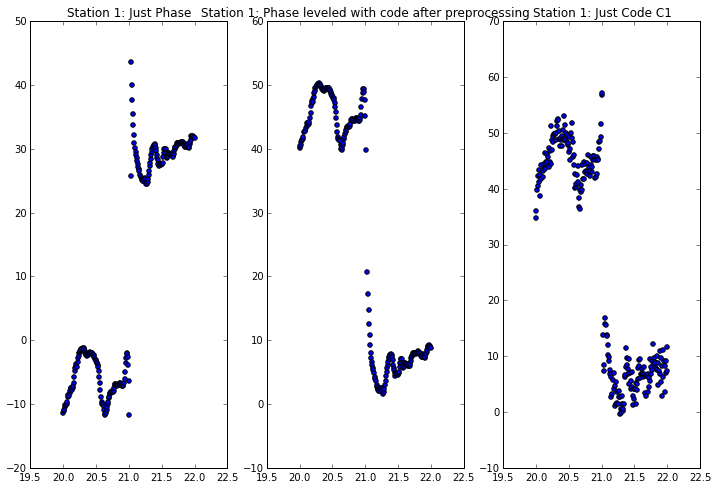

In [23]:
#for some reason usin elevation as a weight doesn't fix the ambiguity
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 1: Just Phase")
plt.scatter(t,IP1)

plt.subplot(1,3,2)
plt.title("Station 1: Phase leveled with code after preprocessing")
plt.scatter(ntimes1[0],new_IPHASE_arc11)
plt.scatter(ntimes1[1],new_IPHASE_arc12)

plt.subplot(1,3,3)
plt.title("Station 1: Just Code C1")
plt.scatter(t,IC1)

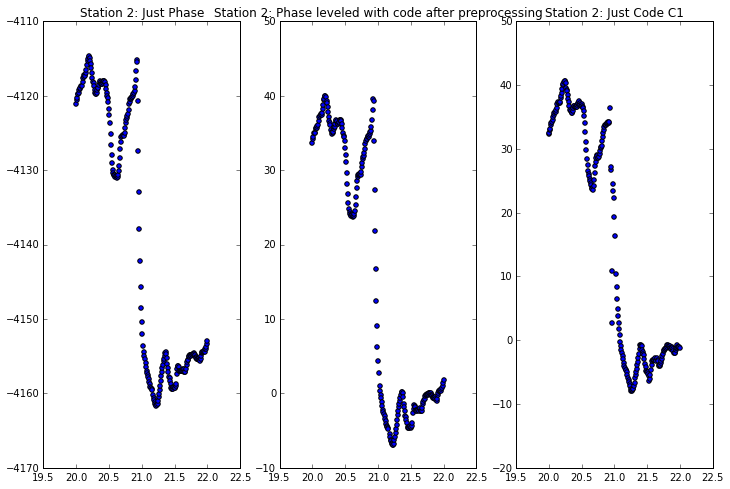

In [24]:
#for some reason usin elevation as a weight doesn't fix the ambiguity
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 2: Just Phase")
plt.scatter(t,IP2)

plt.subplot(1,3,2)
plt.title("Station 2: Phase leveled with code after preprocessing")
plt.scatter(ntimes2[0],new_IPHASE_arc2)

plt.subplot(1,3,3)
plt.title("Station 2: Just Code C1")
plt.scatter(t,IC2)

#FINALLY GRADIENT!

In [25]:
ntimes2=ntimes2[0]
print ntimes1[1][-1] #ultima observacion
print ntimes1[0][-1]

22.0
21.0083333333


In [26]:
print ntimes2[-1]

22.0


In [27]:
ntimes1=np.hstack((ntimes1[0],ntimes1[1])) #podría ese punto hacer falta y dañar el grad
new_IPHASE_arc1=np.hstack((new_IPHASE_arc11,new_IPHASE_arc12 ))
print ntimes1.size,new_IPHASE_arc1.size
print ntimes2.size,new_IPHASE_arc2.size

237 237
238 238


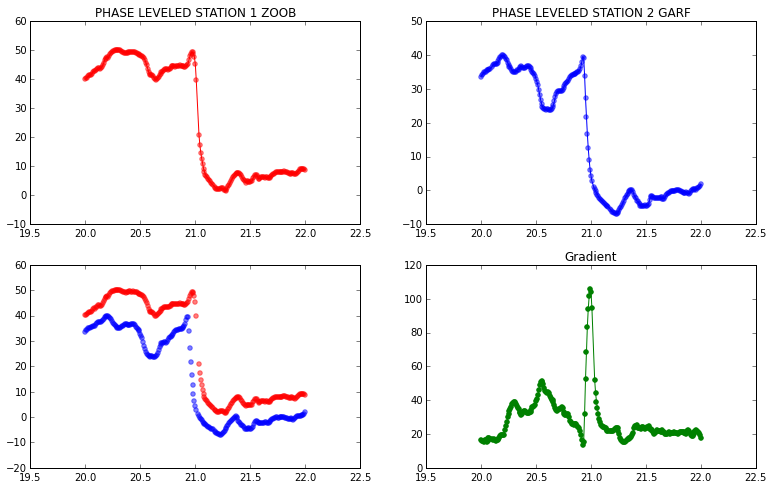

In [28]:
plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("PHASE LEVELED STATION 1 ZOOB")
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red")
plt.subplot(2,2,2)
plt.title("PHASE LEVELED STATION 2 GARF")
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue")
plt.subplot(2,2,3)
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
##arreglo peye ..eliminar tambien el srorc arc en la otra estacion
new_IPHASE_arc2=np.delete(new_IPHASE_arc2,121)
ntimes2=np.delete(ntimes2,121)

gradient=alfa*(-new_IPHASE_arc2+new_IPHASE_arc1) #hace falta un punto ! el del short arc?
plt.subplot(2,2,4)
plt.title("Gradient")
plt.scatter(ntimes1,gradient,color="green")
plt.plot(ntimes1,gradient,color="green")


##Iono gradient WOOS/GARF PRN 26 20.7-21.3 hours 11/20/2003

In [ ]:
st1=["data/woos324.03.n","data/woos324.03.o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,tc1,tp1,tc2,tp2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2=gradient_stationpair(st1,st2,"GPS 26")

In [ ]:
atp1=np.array(tp1)
atp2=np.array(tp2)
#Nos quedamos con los datos entre las 20.7 y 21.3 horas
datos1=atp1[(atp1>=74520) & (atp1<=76680)]
print np.size(datos1)
datos2=atp2[(atp2>=74520) & (atp2<=76680)]
print np.size(datos2)

In [ ]:
print datos1[0:9]+1#estan corridos?
print datos2[1:10]

In [ ]:
tcommon=np.intersect1d(datos1+1,datos2)
print np.size(tcommon)
print np.min(tcommon),np.max(tcommon)
tcommon[(tcommon>=72000.0) & (tcommon<=79200)]

In [ ]:
gradient=[] #iono slopes
#print "Delay 0: ",Iphase1[77160.][0] #delay
#print "IPP: ",Iphase1[77160.][1] #posicion del ipp
t=[]
Id1,Id2=[],[]
for time in tcommon:
    g=np.abs(Iphase1[time-1][0]-Iphase2[time][0])*1000 #mm
    #distance between IPP's (Km)
    d=np.sqrt((Iphase1[time-1][1][0]-Iphase2[time][1][0])**2+(Iphase1[time-1][1][1]-Iphase2[time][1][1])**2+(Iphase1[time-1][1][2]-Iphase2[time][1][2])**2)/1000
    if (g/d)<12e3:
        gradient.append(g/d)
        t.append(time)
        Id1.append(Iphase1[time-1][0])
        Id2.append(Iphase2[time][0])
t=np.array(t)/3600


In [ ]:
D=[]
gg=[]#gradient
IC1,IC2,IPh1,IPh2=[],[],[],[]
t=[]
EL1,EL2=[],[]
for time in tcommon:
    d=np.sqrt((Iphase1[time][1][0]-Iphase2[time][1][0])**2+(Iphase1[time][1][1]-Iphase2[time][1][1])**2+(Iphase1[time][1][2]-Iphase2[time][1][2])**2)/1000
    if Iphase1[time][0]<4e7:
        D.append(d)
        EL1.append(ELEV1[time])
        EL2.append(ELEV2[time])
        IC1.append(Icode1[time][0])
        IC2.append(Icode2[time][0])
        IPh1.append(Iphase1[time][0])
        IPh2.append(Iphase2[time][0])
        t.append(time)


D=np.array(D)
t=np.array(t)/3600 
IC1=np.array(IC1)
IC2=np.array(IC2)
IP1=np.array(IPh1)
IP2=np.array(IPh2)
EL1=np.array(EL1)
EL2=np.array(EL2)
f1=gpstk.L1_FREQ_GPS
f2=gpstk.L2_FREQ_GPS
alfa=f1**2/(f1**2-f2**2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1 ZOB1")
plt.scatter(t,IP1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2 GARF")
plt.scatter(t,IP2)
plt.subplot(3,3,3)
plt.title("Iono Gradient phase")
DelayP=(alfa*(IP2-IP1)*1000)/D #Km/mm
plt.scatter(t,DelayP)
plt.subplot(3,3,4)
plt.title("Iono delay code C1 station 1 ZOB1")
plt.scatter(t,IC1)
plt.subplot(3,3,5)
plt.title("Iono delay code P2 station 1 GARF")
plt.scatter(t,IC2)
plt.subplot(3,3,6)
plt.title("Iono Gradient code ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
DelayC=(alfa*(IC1-IC2)*1000)/D
plt.scatter(t,D)